In [1]:
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, confusion_matrix,
                             plot_precision_recall_curve, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Loading

In [2]:
# Loads dtypes
types = pd.read_csv('./data/processed/transactions_dtypes.csv', index_col=0)
types_dict = types['0'].to_dict()
df = pd.read_csv('./data/processed/transactions.csv', index_col=0)
# sets loaded dtypes to dataframe
df = df.astype(types_dict)

# Constants and Functions

In [3]:
RAND_STATE = 1234

In [4]:
def save_model(model, name):
    with open(f'{name}_{int(datetime.now().timestamp())}.pickle', 'wb') as f:
        pickle.dump(model, f)

In [5]:
def model_results(trained_model):
    """Get's the model results that I want for this specific problem"""
    try:
        print(f"Best Parameters: {trained_model.best_params_}")
    except AttributeError:
        pass
    
    print(
    f"training score: {trained_model.score(X_train, y_train)}",
    f"testing score: {trained_model.score(X_test, y_test)}"
    )
    y_pred_prob = trained_model.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob)}")
    # Uses AP for my threshold
    threshold = average_precision_score(y_test, y_pred_prob)
    print(f"{threshold=}")
    y_pred = trained_model.predict(X_test)
    predictions = np.where(y_pred_prob > threshold, 1, 0)
    print("y_test distribution", np.bincount(y_test))
    print("prediction distribution", np.bincount(predictions == 1))

    # Plot PR Curve
    plot_precision_recall_curve(trained_model, X_test, y_test)
    plt.show()
    
    # Plotting confusion Matrices
    f, axes = plt.subplots(1, 2, sharey=True, figsize=[15, 5])
    axes[0].set_title("Confusion Matrix 50/50")
    sns.heatmap(confusion_matrix(y_test.to_numpy(), y_pred), annot=True, fmt='g', ax=axes[0])
    axes[1].set_title("Confusion Matrix - Custom Threshold")
    sns.heatmap(confusion_matrix(y_test.to_numpy(), predictions), annot=True, fmt='g', ax=axes[1])
    plt.show()

In [6]:
def feature_importance(pipeline: Pipeline, X_train: pd.DataFrame):
    """ Plots feature importance. Assumes a Pipeline, with classifier as name"""
    importance = pd.Series(pipeline.best_estimator_.named_steps["classifier"].feature_importances_, index=X_train.columns)
    plt.figure( figsize = (10, 5) )
    importance.sort_values(ascending = False).plot.bar()
    plt.show()

# Splitting and Sampling 

In [7]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RAND_STATE)
X_train.shape


(582501, 34)

# Models

## Logistic Regression

### Basic LogReg

In [9]:
# Basic log regression with pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', LogisticRegression(random_state=RAND_STATE, n_jobs=-1))
    ])

In [10]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('classifier',
                 LogisticRegression(n_jobs=-1, random_state=1234))])

In [11]:
save_model(pipeline, "logreg_pipeline")

training score: 0.9843708422818158 testing score: 0.9842712716373019
ROC AUC Score: 0.7561357058659209
threshold=0.05488260915755708
y_test distribution [191165   3002]
prediction distribution [190999   3168]


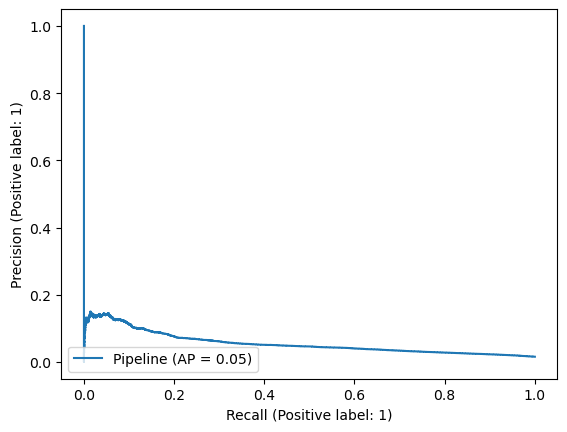

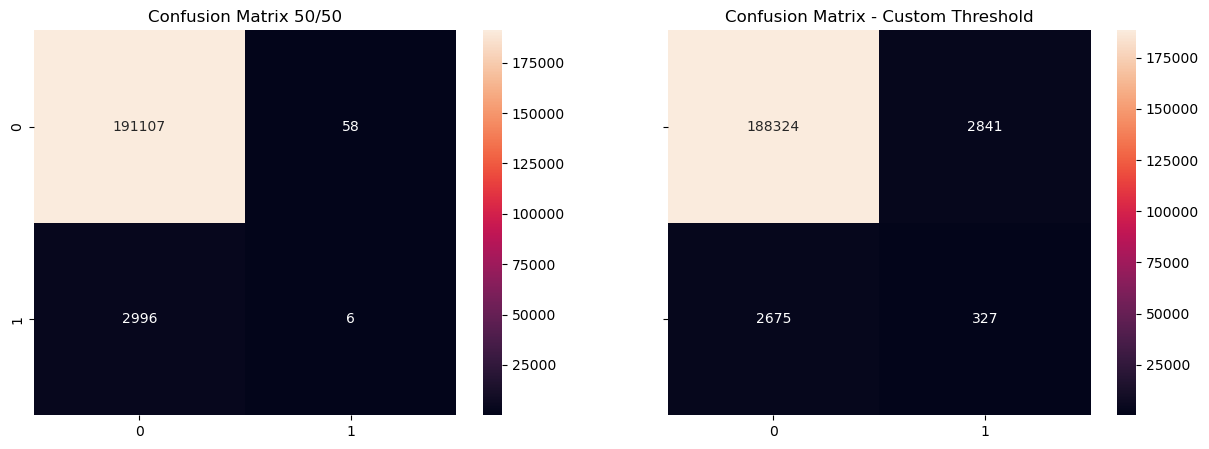

In [12]:
model_results(pipeline)

### Grid Search Pipeline

In [13]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', LogisticRegression(random_state=RAND_STATE, n_jobs=-1))
    ])

In [14]:
logreg_params = {
    'classifier__solver': ['newton-cg', 'lbfgs'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, scoring='roc_auc', refit=True, cv=5, n_jobs=-1)

In [15]:
logreg_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', VarianceThreshold()),
                                       ('classifier',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=1234))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['newton-cg', 'lbfgs']},
             scoring='roc_auc')

In [16]:
save_model(logreg_grid, "logreg_grid")

Best Parameters: {'classifier__C': 0.001, 'classifier__solver': 'newton-cg'}
training score: 0.7569003802412374 testing score: 0.7591542603712887
ROC AUC Score: 0.7591542603712887
threshold=0.0556244167479321
y_test distribution [191165   3002]
prediction distribution [191840   2327]


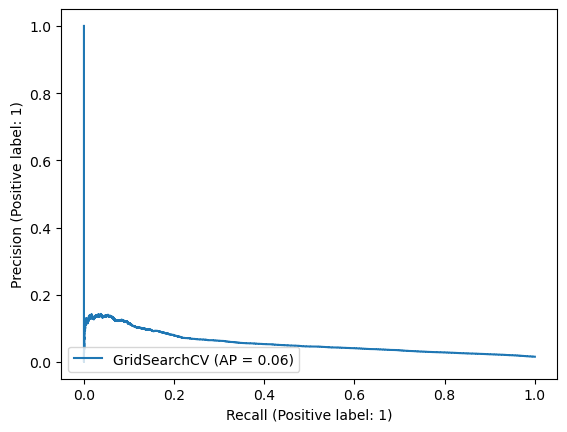

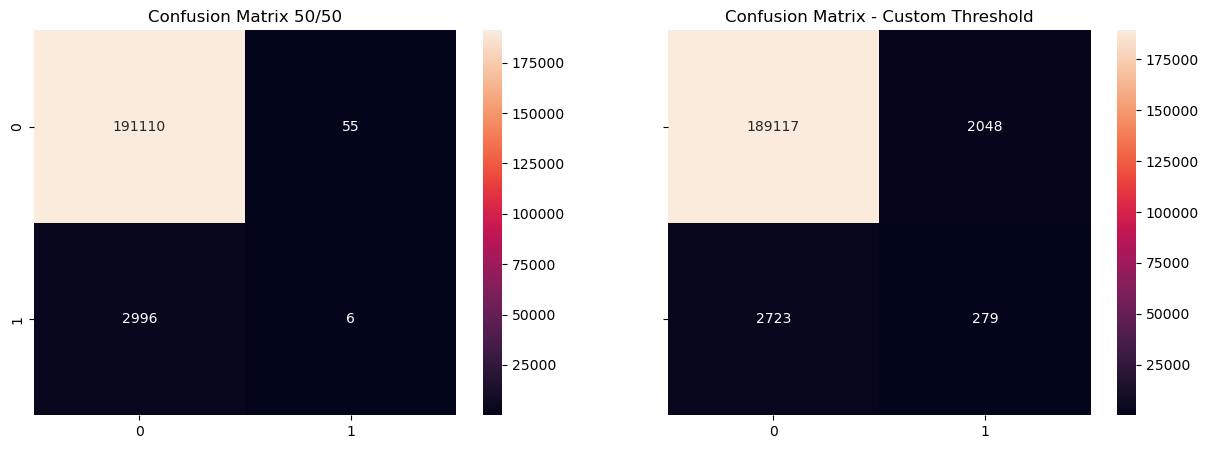

In [17]:
model_results(logreg_grid)

## Random Forest

In [18]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=RAND_STATE, n_jobs=-1)

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
    ])
rf_params = {
    'classifier__n_estimators': [80, 100, 120],
    'classifier__max_depth': [5],
    'classifier__max_features': [5, 6, 7]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, scoring='roc_auc', cv=5, n_jobs=-1, refit=True)


In [19]:
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1234))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5],
                         'classifier__max_features': [5, 6, 7],
                         'classifier__n_estimators': [80, 100, 120]},
             scoring='roc_auc')

In [20]:
save_model(rf_grid, "rf_grid")

Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 7, 'classifier__n_estimators': 80}
training score: 0.8025574747634265 testing score: 0.8008447249519335
ROC AUC Score: 0.8008447249519335
threshold=0.1171574501526548
y_test distribution [191165   3002]
prediction distribution [193933    234]


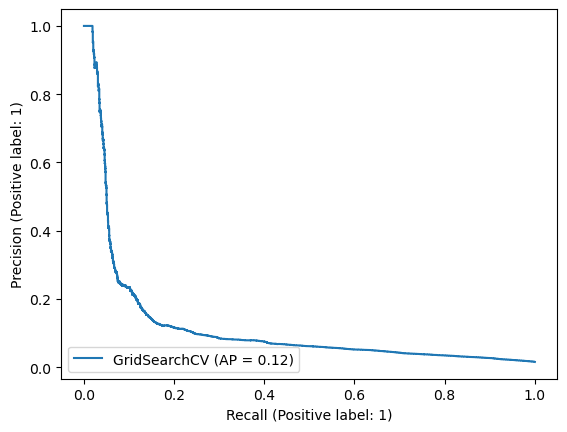

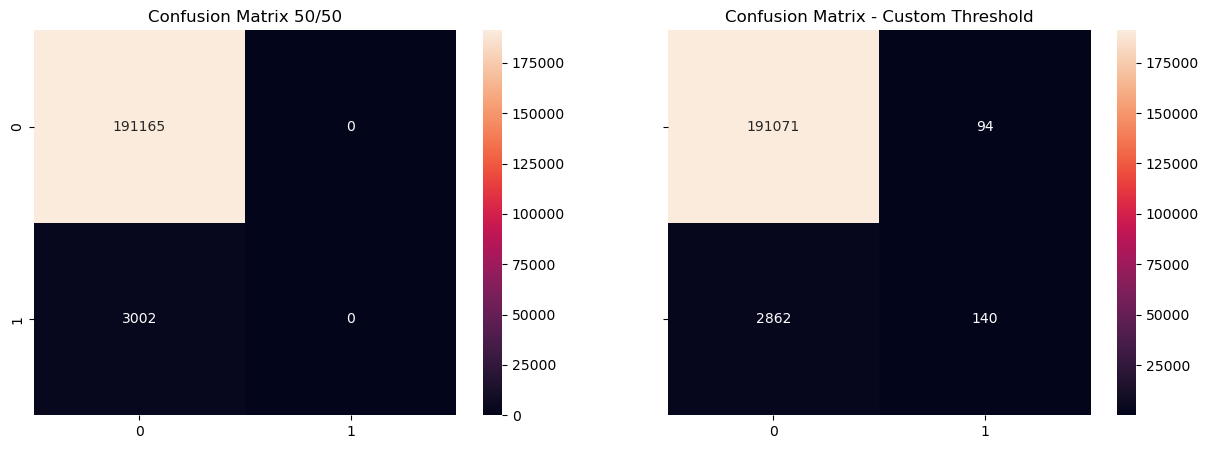

In [21]:
model_results(rf_grid)

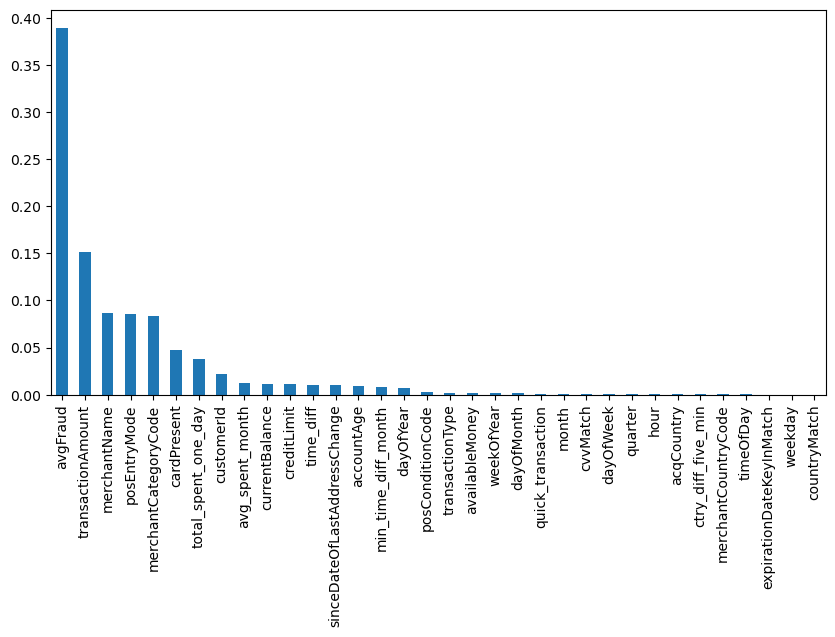

In [22]:
feature_importance(rf_grid, X_train)

## Gradient Boosting Classifier

In [23]:
gb_model = GradientBoostingClassifier(random_state=RAND_STATE)
gb_pipeline = Pipeline([
    ('classifier', gb_model),
    ])
gb_params = {
    'classifier__max_depth': [3, 5, None],
    'classifier__max_features': [4, 6, 8]
}
gb_grid = GridSearchCV(gb_pipeline, gb_params, scoring='roc_auc', cv=5, n_jobs=-1, refit=True)

In [24]:
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier(random_state=1234))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, None],
                         'classifier__max_features': [4, 6, 8]},
             scoring='roc_auc')

In [25]:
save_model(gb_grid, "gb_grid")

Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 8}
training score: 0.8505109094223827 testing score: 0.8356391129790751
ROC AUC Score: 0.8356391129790751
threshold=0.16221412502163715
y_test distribution [191165   3002]
prediction distribution [193173    994]


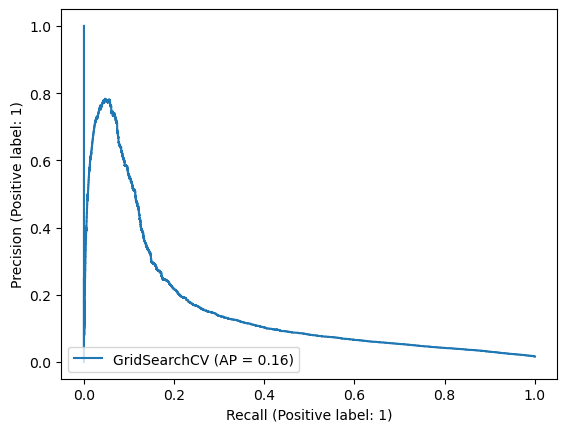

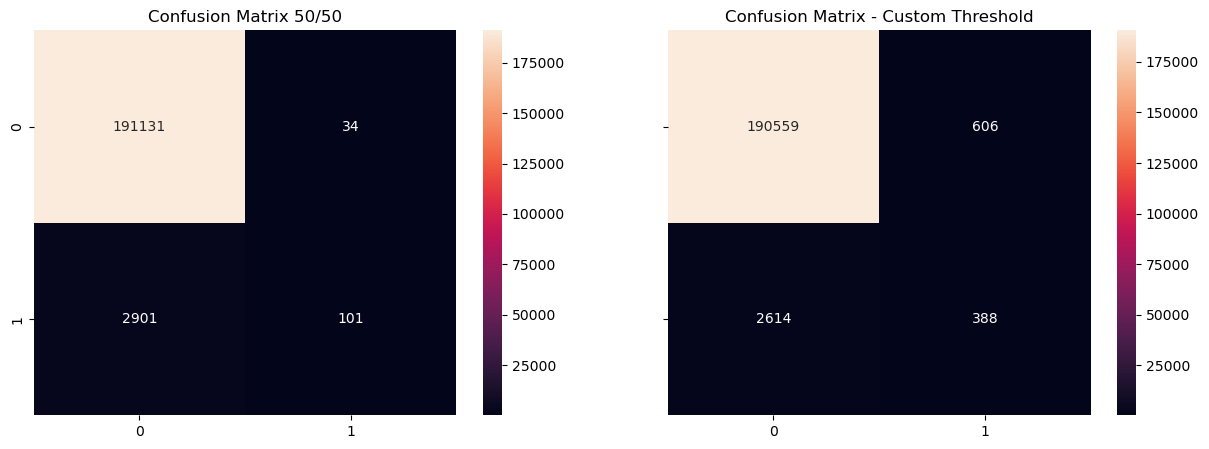

In [26]:
model_results(gb_grid)

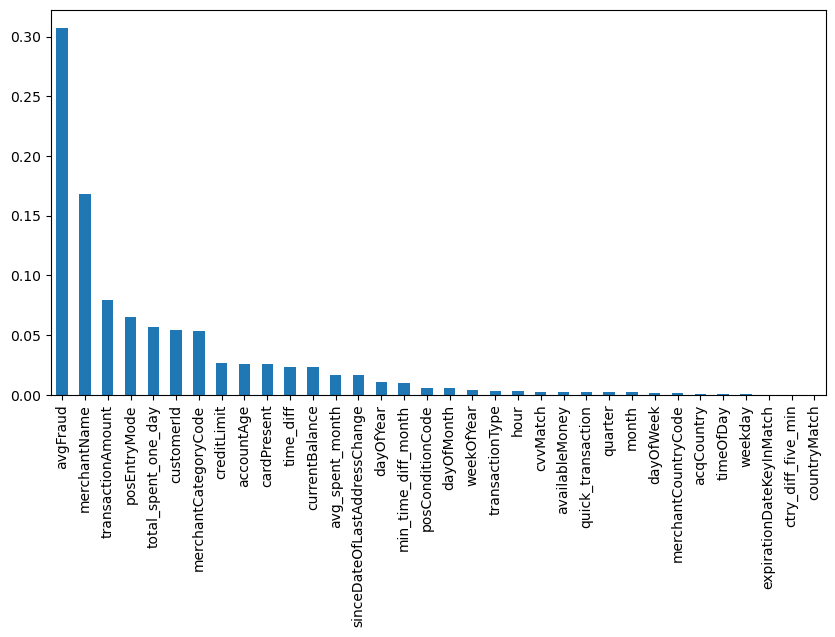

In [27]:
feature_importance(gb_grid, X_train)

# Which Model is Best?

First of all, modifying the threshold greatly improved the results. Naturally there is more noise, but there are more true positives (tp) and less false negatives (fn).

In trying to improve tp and reduce fn , the Gradient Boost did best, but the Logistic Regression Model wasn't much worse.
